In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
# %qtconsole

In [2]:
import pandas as pd
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import logging
logging.basicConfig(level=logging.INFO)

np.random.seed(1234)

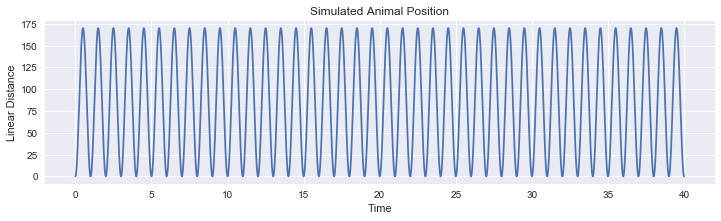

In [3]:
SAMPLING_FREQUENCY = 1500
N_SAMPLES = SAMPLING_FREQUENCY * 40
TRACK_HEIGHT = 170
fig = plt.figure(figsize=(12, 3))
time = np.arange(N_SAMPLES) / SAMPLING_FREQUENCY
linear_distance = (TRACK_HEIGHT / 2) * np.sin(2 * np.pi * time - (np.pi) / 2) + (TRACK_HEIGHT / 2)
plt.plot(time, linear_distance);
plt.ylabel('Linear Distance')
plt.xlabel('Time')
plt.title('Simulated Animal Position');

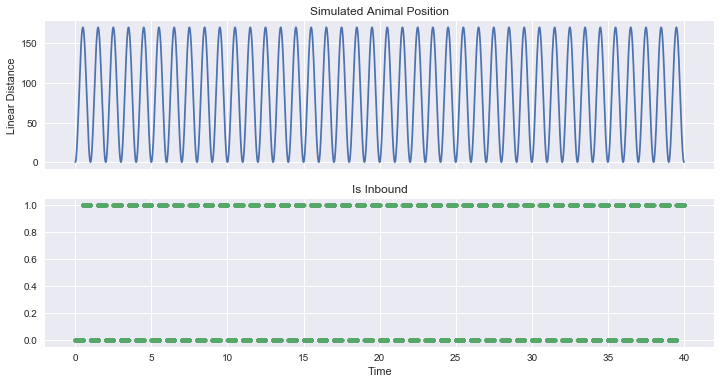

In [4]:
is_inbound = np.insert(np.diff(linear_distance) < 0, 0, False)
trajectory_direction = np.where(is_inbound, 'Inbound', 'Outbound')

fig, axes = plt.subplots(2, 1, figsize=(12, 6), sharex=True)
time = np.arange(N_SAMPLES) / SAMPLING_FREQUENCY
linear_distance = (TRACK_HEIGHT / 2) * np.sin(2 * np.pi * time - (np.pi) / 2) + (TRACK_HEIGHT / 2)
axes[0].plot(time, linear_distance);
axes[0].set_ylabel('Linear Distance')
axes[1].set_xlabel('Time')
axes[0].set_title('Simulated Animal Position');

axes[1].plot(time, is_inbound, color='C1', linestyle='None', marker='.')
axes[1].set_title('Is Inbound');

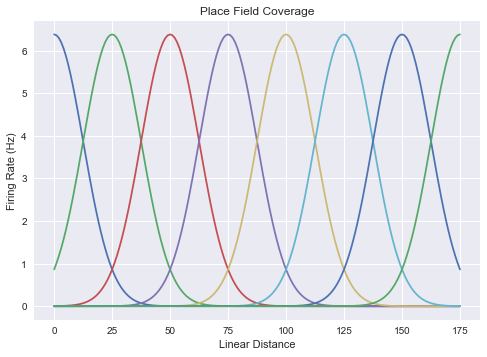

In [5]:
from scipy.stats import norm

place_field_support = np.arange(0, 176)
place_field_means = np.arange(0, 200, 25)[:, np.newaxis]
plt.plot(place_field_support, 2E2 * norm(place_field_means, 12.5).pdf(place_field_support).T)
plt.xlabel('Linear Distance')
plt.ylabel('Firing Rate (Hz)')
plt.title('Place Field Coverage');

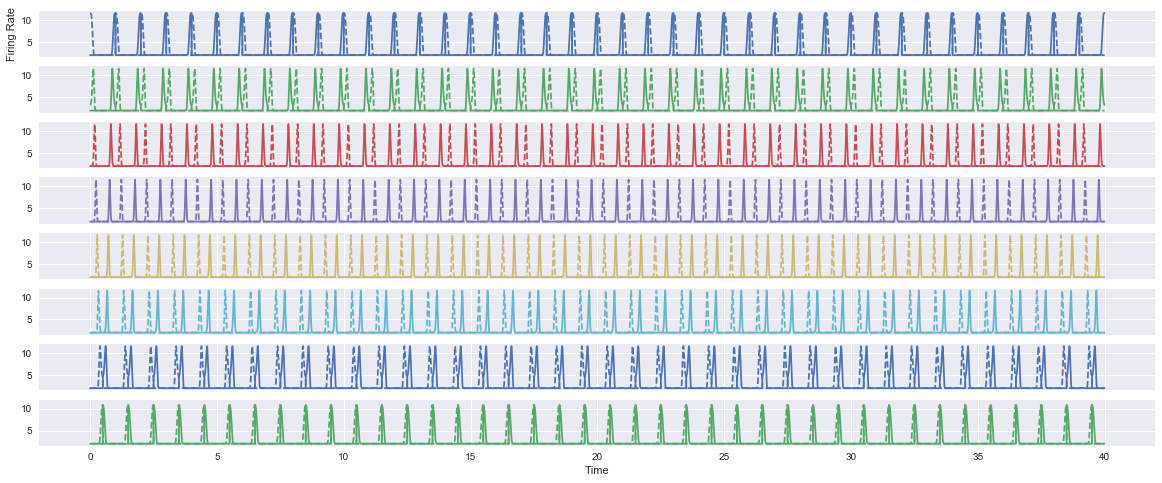

In [6]:
baseline_firing_rate = 2
n_neurons = len(place_field_means)
fig, axes = plt.subplots(n_neurons, 1, figsize=(20, n_neurons), sharex=True, sharey=True)
place_fields_over_time_inbound = (3E2 * norm(place_field_means, 12.5).pdf(linear_distance)  * is_inbound) + baseline_firing_rate
colors = ['C{0}'.format(n) for n in range(n_neurons)]
for place_field, ax, color in zip(place_fields_over_time_inbound, axes, colors):
    ax.plot(time, place_field, color=color)

place_fields_over_time_outbound = (3E2 * norm(place_field_means, 12.5).pdf(linear_distance)  * ~is_inbound) + baseline_firing_rate
for place_field, ax, color in zip(place_fields_over_time_outbound, axes, colors):
    ax.plot(time, place_field, color=color, linestyle='--')
    
axes[-1].set_xlabel('Time')
axes[0].set_ylabel('Firing Rate');

In [7]:
firing_rates = np.concatenate((place_fields_over_time_inbound, place_fields_over_time_outbound))
firing_rates.shape

(16, 60000)

In [8]:
from scipy.stats import poisson

dt = 1 / SAMPLING_FREQUENCY

spikes = poisson.rvs(firing_rates * dt).T

## Decode Simulated Data

In [9]:
from src.ripple_decoding import SortedSpikeDecoder

decoder = SortedSpikeDecoder(linear_distance, spikes, trajectory_direction, replay_speedup_factor=1)

/Users/edeno/anaconda3/envs/Jadhav-2016-Data-Analysis/lib/python3.5/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [10]:
decoder.fit();

INFO:src.ripple_decoding.decoders:Fitting state transition model...
INFO:src.ripple_decoding.decoders:Fitting observation model...


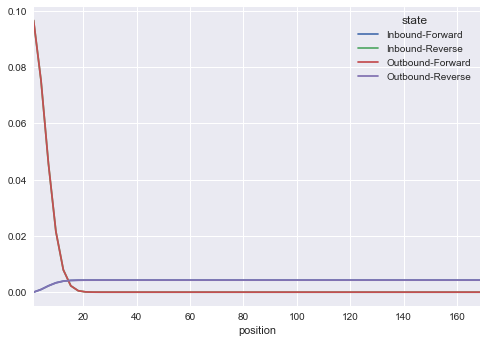

In [11]:
decoder.plot_initial_conditions();

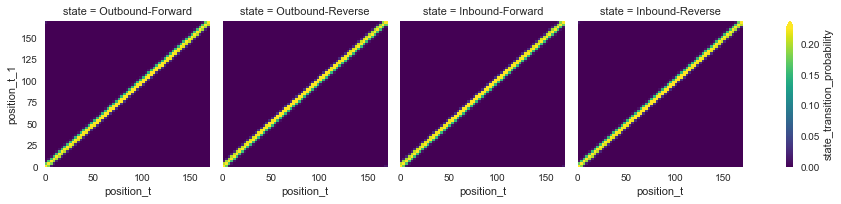

In [12]:
decoder.plot_state_transition_model();

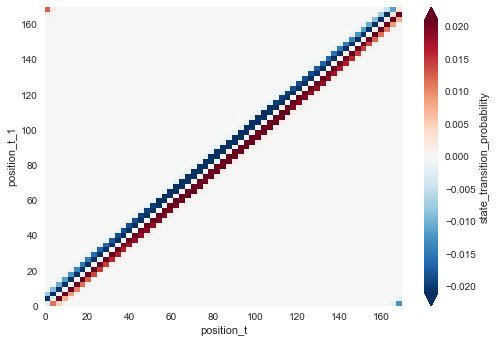

In [53]:
state_transition = decoder.state_transition_matrix

(state_transition.sel(state='Outbound-Forward') - state_transition.sel(state='Inbound-Forward')).plot(
    x='position_t', y='position_t_1', robust=True);

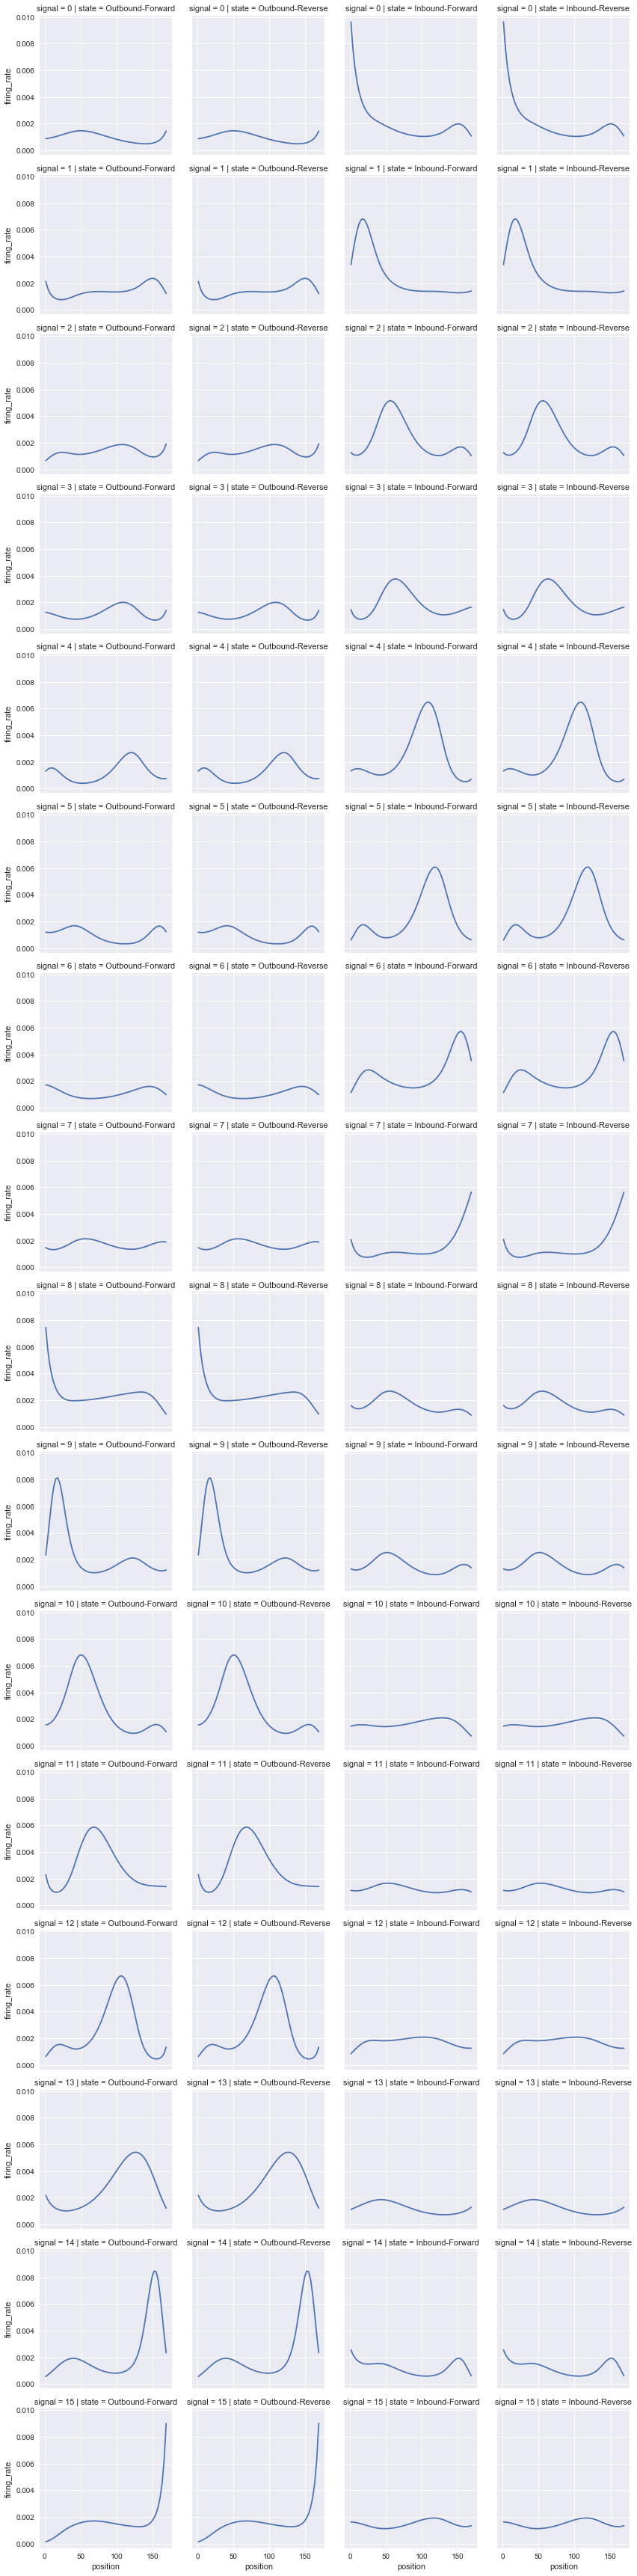

In [14]:
decoder.plot_observation_model();

### Outbound-Forward

In [15]:
outbound_time = time < 0.5
outbound_results = decoder.predict(spikes[outbound_time].T, time=time[outbound_time])

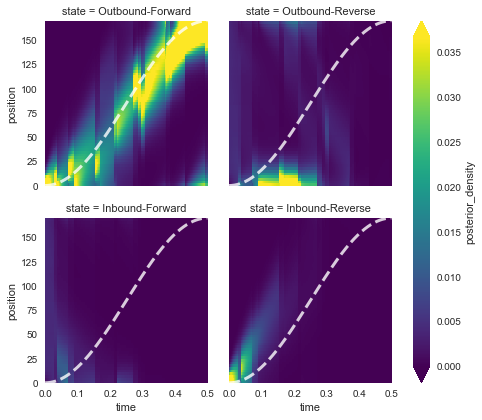

In [16]:
g = outbound_results.plot_posterior_density()

for ax in g.axes.ravel().tolist():
    ax.plot(time[outbound_time], linear_distance[outbound_time], color='white', linestyle='--', linewidth=3, alpha=0.8)

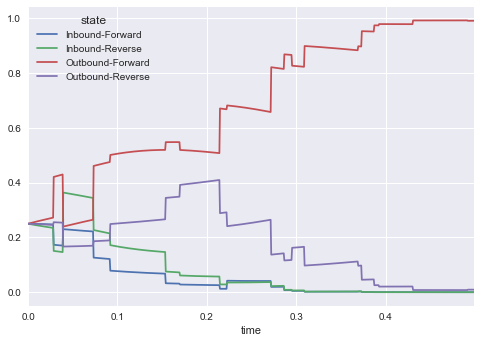

In [17]:
outbound_results.plot_state_probability();

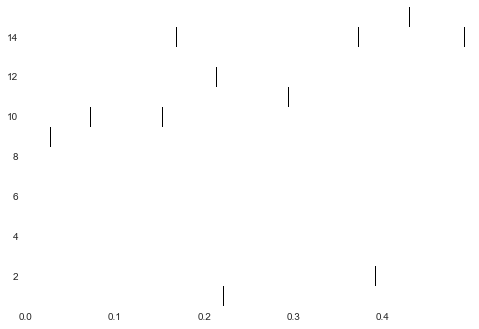

In [18]:
plt.pcolormesh(time[outbound_time], np.arange(n_neurons * 2) + 0.5, outbound_results.spikes);

### Inbound-Forward

In [19]:
inbound_time = (time > 1.5) & (time <= 2)
inbound_results = decoder.predict(spikes[inbound_time].T, time=time[inbound_time])

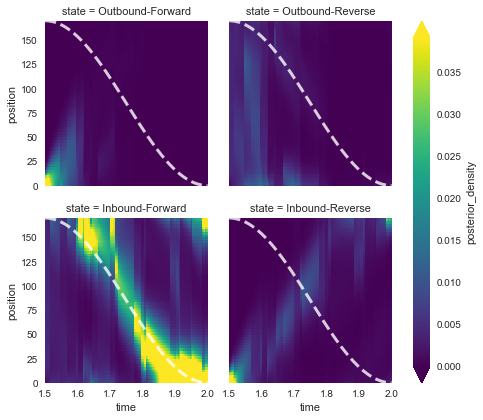

In [20]:
g = inbound_results.plot_posterior_density()

for ax in g.axes.ravel().tolist():
    ax.plot(time[inbound_time], linear_distance[inbound_time], color='white', linestyle='--', linewidth=3, alpha=0.8)

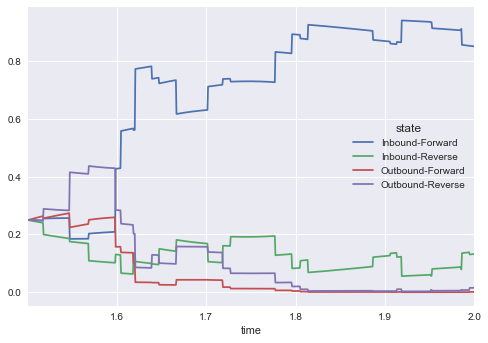

In [21]:
inbound_results.plot_state_probability();

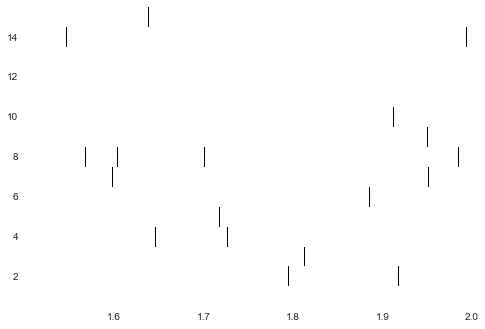

In [22]:
plt.pcolormesh(time[inbound_time], np.arange(n_neurons * 2) + 0.5, inbound_results.spikes);

### Longer time

In [23]:
all_time = time <= 3
all_time_results = decoder.predict(spikes[all_time].T, time=time[all_time])

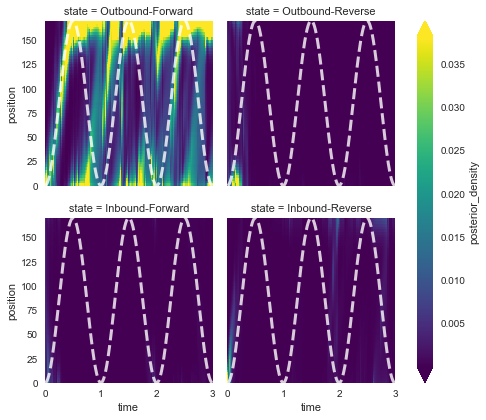

In [24]:
g = all_time_results.plot_posterior_density()

for ax in g.axes.ravel().tolist():
    ax.plot(time[all_time], linear_distance[all_time], color='white', linestyle='--', linewidth=3, alpha=0.8)

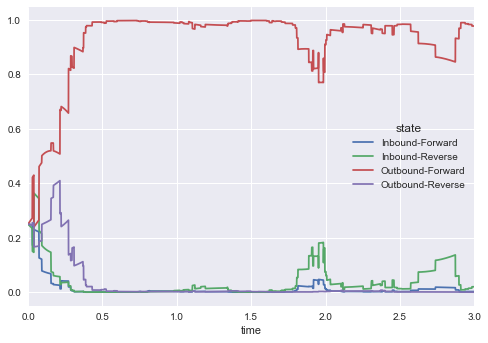

In [25]:
all_time_results.plot_state_probability();

## Decode Replay Simulation

In [26]:
decoder_spedup = SortedSpikeDecoder(linear_distance, spikes, trajectory_direction, replay_speedup_factor=10)

In [27]:
decoder_spedup.fit();

INFO:src.ripple_decoding.decoders:Fitting state transition model...
INFO:src.ripple_decoding.decoders:Fitting observation model...


In [28]:
replay_time = np.arange(n_neurons * 10) / SAMPLING_FREQUENCY

### Inbound-Forward

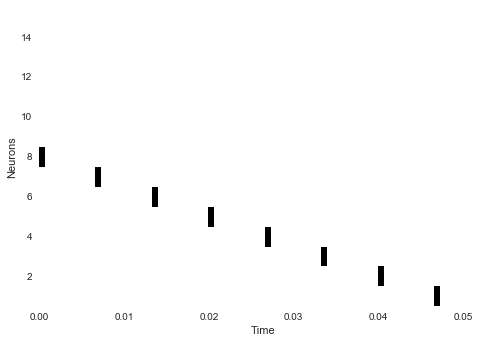

In [29]:
inbound_forward_replay_spikes = np.zeros((n_neurons * 2, replay_time.size))
inbound_forward_replay_spikes[:, ::10] = np.concatenate((np.fliplr(np.identity(n_neurons)), np.zeros((n_neurons, n_neurons))))
plt.pcolormesh(replay_time, np.arange(n_neurons * 2) + 0.5, inbound_forward_replay_spikes);
plt.xlabel('Time')
plt.ylabel('Neurons');

In [30]:
inbound_forward_results = decoder_spedup.predict(inbound_forward_replay_spikes, replay_time)

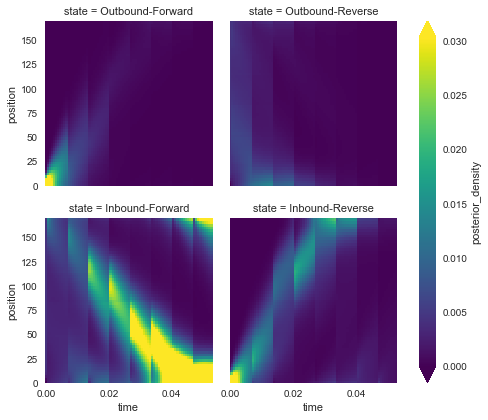

In [31]:
inbound_forward_results.plot_posterior_density();

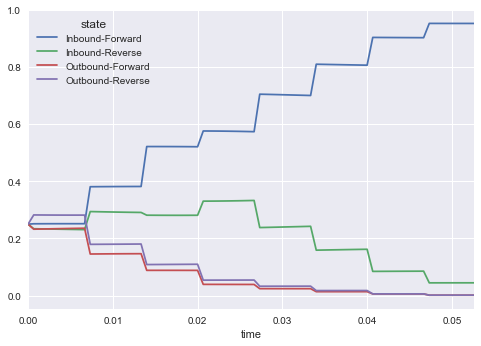

In [32]:
inbound_forward_results.plot_state_probability();

### Outbound-Forward

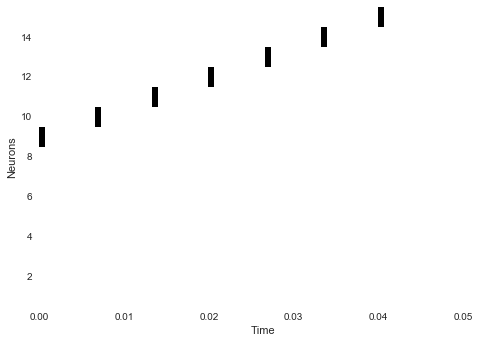

In [33]:
outbound_forward_replay_spikes = np.zeros((n_neurons * 2, replay_time.size))
outbound_forward_replay_spikes[:, ::10] = np.concatenate((np.zeros((n_neurons, n_neurons)), np.identity(n_neurons)))
plt.pcolormesh(replay_time, np.arange(n_neurons * 2) + 0.5, outbound_forward_replay_spikes);
plt.xlabel('Time')
plt.ylabel('Neurons');

In [34]:
outbound_forward_results = decoder_spedup.predict(outbound_forward_replay_spikes, replay_time)

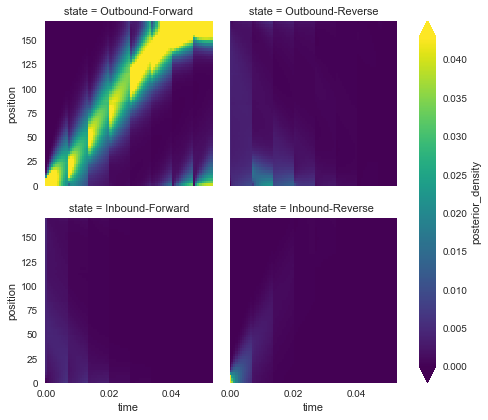

In [35]:
outbound_forward_results.plot_posterior_density();

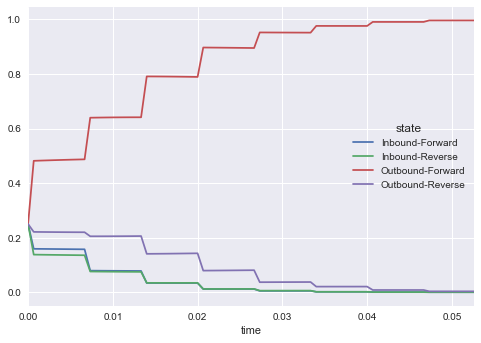

In [36]:
outbound_forward_results.plot_state_probability();

### Inbound Reverse

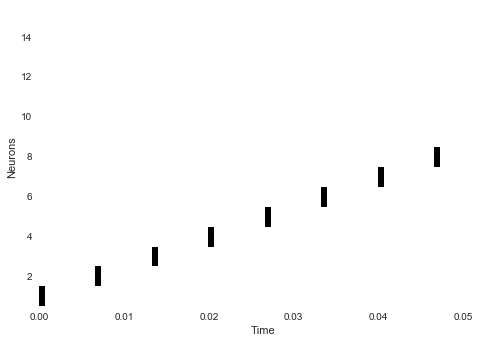

In [37]:
inbound_reverse_replay_spikes = np.zeros((n_neurons * 2, replay_time.size))
inbound_reverse_replay_spikes[:, ::10] = np.concatenate((np.identity(n_neurons), np.zeros((n_neurons, n_neurons))))
plt.pcolormesh(replay_time, np.arange(n_neurons * 2) + 0.5, inbound_reverse_replay_spikes);
plt.xlabel('Time')
plt.ylabel('Neurons');

In [38]:
inbound_reverse_results = decoder_spedup.predict(inbound_reverse_replay_spikes, replay_time)

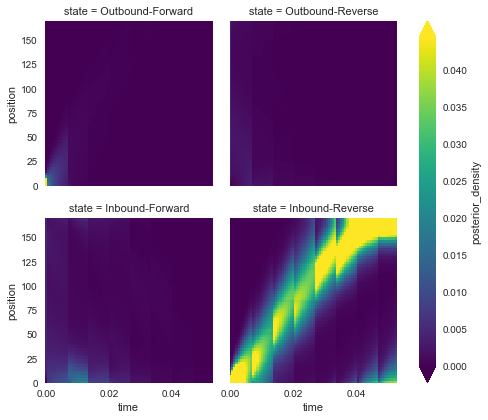

In [39]:
inbound_reverse_results.plot_posterior_density();

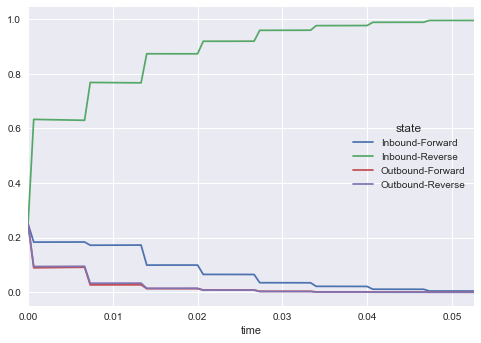

In [40]:
inbound_reverse_results.plot_state_probability();

### Outbound-Reverse

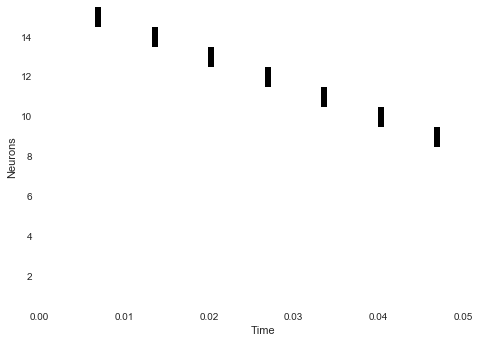

In [41]:
outbound_reverse_replay_spikes = np.zeros((n_neurons * 2, replay_time.size))
outbound_reverse_replay_spikes[:, ::10] = np.concatenate((np.zeros((n_neurons, n_neurons)), np.fliplr(np.identity(n_neurons))))
plt.pcolormesh(replay_time, np.arange(n_neurons * 2) + 0.5, outbound_reverse_replay_spikes);
plt.xlabel('Time')
plt.ylabel('Neurons');

In [42]:
outbound_reverse_results = decoder_spedup.predict(outbound_reverse_replay_spikes, replay_time)

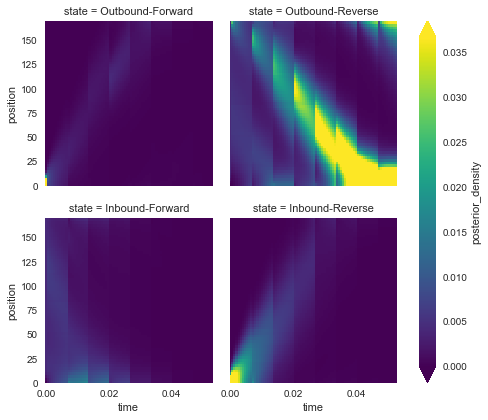

In [43]:
outbound_reverse_results.plot_posterior_density();

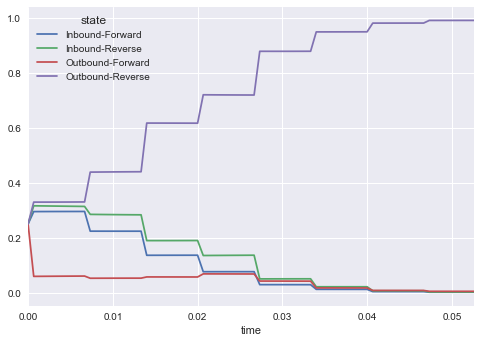

In [44]:
outbound_reverse_results.plot_state_probability();

### No state

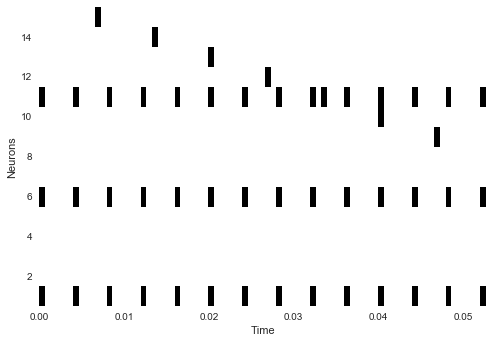

In [45]:
no_state_replay_spikes = np.zeros((n_neurons * 2, replay_time.size))
no_state_replay_spikes[:, ::10] = np.concatenate((np.zeros((n_neurons, n_neurons)), np.fliplr(np.identity(n_neurons))))
no_state_replay_spikes[::5, ::6] = 1

plt.pcolormesh(replay_time, np.arange(n_neurons * 2) + 0.5, no_state_replay_spikes);
plt.xlabel('Time')
plt.ylabel('Neurons');

In [46]:
no_state_results = decoder_spedup.predict(no_state_replay_spikes, replay_time)

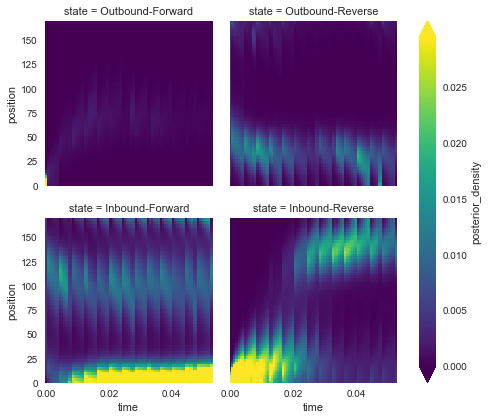

In [47]:
no_state_results.plot_posterior_density();

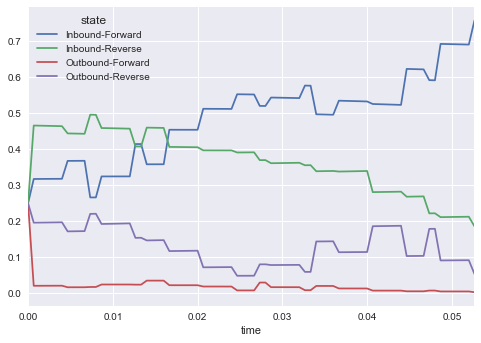

In [48]:
no_state_results.plot_state_probability();